# Adversarial Poisoning Attack on Deployed MNIST Classifier
# ===============================================

#### This notebook demonstrates how to perform a gradient-based poisoning attack
#### against a deployed machine learning model trained on the MNIST dataset.
#### We'll interact with the model's API endpoints defined in deploy.py.


In [2]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import requests
import json
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-04-15 11:29:52.742994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 11:29:52.768823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744712992.789369    5851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744712992.795127    5851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744712992.810905    5851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:


# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [4]:

# Set parameters for the poisoning attack
TARGET_DIGIT = 7  # The digit we want to misclassify
TARGET_LABEL = 1  # The incorrect class we want the model to predict (7→1)
POISON_RATIO = 0.05  # Percentage of training samples to poison
MAX_ITERATIONS = 10  # Increased iterations for more effective attack
LEARNING_RATE = 0.2  # Increased learning rate for stronger impact
EPSILON = 0.4  # Increased perturbation allowed for better attack success

In [5]:


# API endpoints for the deployed model
API_URL = "http://localhost:5000"
INFO_ENDPOINT = f"{API_URL}/info"
PREDICT_ENDPOINT = f"{API_URL}/predict_raw"
GRADIENT_ENDPOINT = f"{API_URL}/get_gradient"


# ===============================================
# 1. Load and prepare the MNIST dataset
# ===============================================


Loading MNIST dataset...
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Data preprocessing completed.


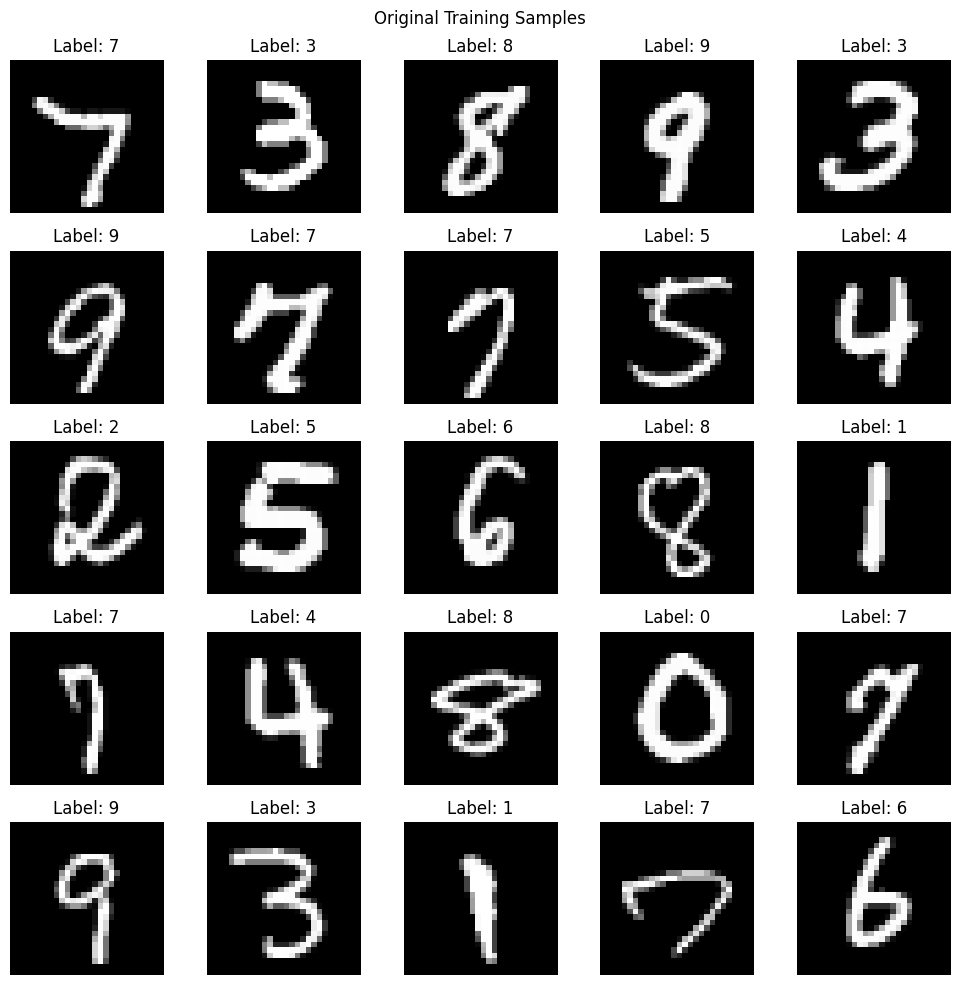

In [6]:

print("Loading MNIST dataset...")
# Load the MNIST dataset
(x_train_original, y_train_original), (x_test, y_test) = mnist.load_data()

# Print dataset shapes
print(f"Training data shape: {x_train_original.shape}")
print(f"Training labels shape: {y_train_original.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Preprocess the data (normalize pixel values between 0 and 1)
x_train_original = x_train_original.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_train_original = x_train_original.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train_original_cat = to_categorical(y_train_original, 10)
y_test_cat = to_categorical(y_test, 10)

print("Data preprocessing completed.")

# Function to visualize sample images
def visualize_samples(images, labels, title, num_samples=25):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(5, 5, i+1)
        # Reshape if the image has a channel dimension
        if len(images[i].shape) == 3:
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display random samples from the training set
indices = np.random.choice(len(x_train_original), 25, replace=False)
visualize_samples(x_train_original[indices], y_train_original[indices], "Original Training Samples")

# ===============================================
# 2. Test Connection to the Deployed Model
# ===============================================


Testing connection to the deployed model...
Successfully connected to the model API!
Model name: MNIST Digit Classifier
Model accuracy: 0.9908999800682068
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Testing prediction with a sample image...


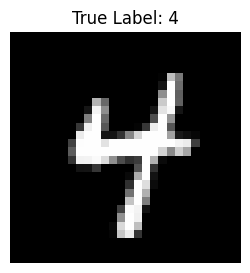

Predicted Class: 4
Confidence: 1.0000


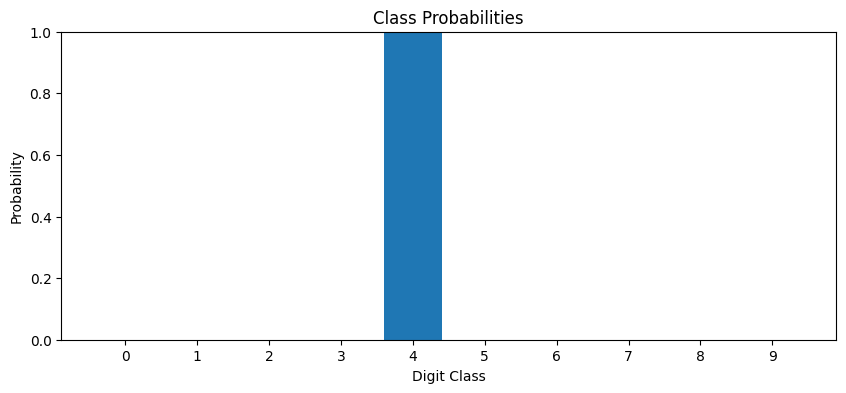


Testing gradient computation...
Successfully retrieved gradient information.


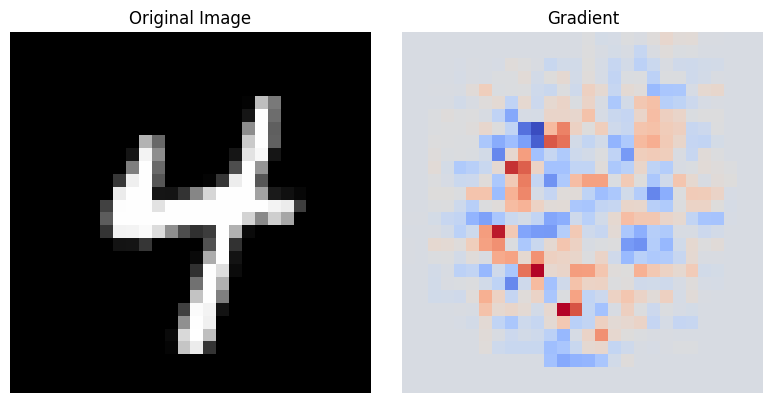

In [7]:


def get_model_info():
    """Get information about the deployed model"""
    try:
        response = requests.get(INFO_ENDPOINT)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error connecting to the model API: {e}")
        return None

def predict_digit(image_data):
    """
    Send an image to the deployed model for prediction
    
    Args:
        image_data: Numpy array of the image (28x28x1)
        
    Returns:
        The prediction results
    """
    # Flatten the image data
    pixels = image_data.flatten().tolist()
    
    # Create request payload
    payload = {
        "pixels": pixels
    }
    
    # Send request to the predict endpoint
    try:
        response = requests.post(PREDICT_ENDPOINT, json=payload)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error sending prediction request: {e}")
        return None

def get_gradient(image_data, label):
    """
    Get the gradient of the loss with respect to the input
    
    Args:
        image_data: Numpy array of the image (28x28x1)
        label: The true label of the image
        
    Returns:
        The gradient information
    """
    # Flatten the image data
    pixels = image_data.flatten().tolist()
    
    # Create request payload
    payload = {
        "pixels": pixels,
        "label": int(label)
    }
    
    # Send request to the gradient endpoint
    try:
        response = requests.post(GRADIENT_ENDPOINT, json=payload)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error getting gradient: {e}")
        return None

# Test connection to the model API
print("\nTesting connection to the deployed model...")
model_info = get_model_info()
if model_info:
    print("Successfully connected to the model API!")
    print(f"Model name: {model_info.get('model_name', 'Unknown')}")
    print(f"Model accuracy: {model_info.get('test_accuracy', 'Unknown')}")
    print(f"Classes: {model_info.get('classes', 'Unknown')}")
else:
    print("Failed to connect to the model API. Please make sure the model is running at", API_URL)

# Test prediction with a sample image
if model_info:
    print("\nTesting prediction with a sample image...")
    sample_idx = np.random.choice(len(x_test))
    sample_image = x_test[sample_idx]
    sample_label = y_test[sample_idx]
    
    # Display the sample image
    plt.figure(figsize=(3, 3))
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f"True Label: {sample_label}")
    plt.axis('off')
    plt.show()
    
    # Get prediction from the deployed model
    prediction_result = predict_digit(sample_image)
    if prediction_result:
        predicted_class = prediction_result.get('predicted_class')
        confidence = prediction_result.get('confidence')
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")
        
        # Display class probabilities
        class_probs = prediction_result.get('class_probabilities', {})
        plt.figure(figsize=(10, 4))
        plt.bar(class_probs.keys(), class_probs.values())
        plt.title("Class Probabilities")
        plt.xlabel("Digit Class")
        plt.ylabel("Probability")
        plt.ylim(0, 1)
        plt.show()
    
    # Test gradient computation
    print("\nTesting gradient computation...")
    gradient_result = get_gradient(sample_image, sample_label)
    if gradient_result:
        print("Successfully retrieved gradient information.")
        gradient = np.array(gradient_result.get('gradient', []))
        gradient_shape = gradient_result.get('gradient_shape', None)
        
        if gradient_shape:
            # Reshape the gradient to match the input shape
            gradient = gradient.reshape(gradient_shape)
            
            # Visualize the gradient
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(sample_image.reshape(28, 28), cmap='gray')
            plt.title("Original Image")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(gradient[0, :, :, 0], cmap='coolwarm')
            plt.title("Gradient")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    else:
        print("Failed to get gradient information.")



# ===============================================
# 3. Understanding Poisoning Attacks
# ===============================================



## What is a Poisoning Attack?

Poisoning attacks are a class of adversarial attacks that target the training phase
of machine learning models. Unlike evasion attacks that occur during inference,
poisoning attacks manipulate the training data to influence the model's behavior.

As described in the Security and Privacy of AI Knowledge Guide, these attacks can be
formulated as an optimization problem:

maximize L(θ*, {x*_i, y*_i})
subject to θ* = argmin L(θ, {x_i, y_i} ∪ {x*_i, y*_i})
           constraints on {x*_i, y*_i}

Where:
- L is the model's loss function
- θ represents the model parameters
- {x_i, y_i} is the original training dataset
- {x*_i, y*_i} are the poisoned samples

## Types of Poisoning Attacks:

1. **Availability Attacks**: These aim to reduce the overall performance of the model
   by injecting samples that cause the model to make errors across multiple classes.

2. **Integrity Attacks**: These aim to create specific misclassifications while
   maintaining overall model performance. These can be further classified as:
   - **Clean-label attacks**: The poisoned samples maintain their original labels
   - **Label-flipping attacks**: The labels of the poisoned samples are changed

3. **Targeted vs. Untargeted**: Targeted attacks aim to cause misclassification of
   specific inputs, while untargeted attacks aim to degrade overall performance.

## Attacking a Deployed Model:

While poisoning attacks typically occur during training, we'll simulate a scenario where
we want to generate poisoned samples for a model that's already been trained and deployed.
This is a realistic scenario where:

1. We have access to the deployed model's API
2. We're able to query the model for predictions and gradients
3. We want to create poisoned samples that would cause misclassification if included
   in future retraining of the model

This demonstrates how an attacker might prepare poisoned data to inject into a data
collection pipeline, ultimately affecting future versions of the model.



# ===============================================
# 4. Implementing the Poisoning Attack Against the Deployed Model
# ===============================================

"""
#### Approach for Attacking the Deployed Model

Our approach for creating poisoned training data using the deployed model:

1. Select a subset of training samples of the target class (digit 7)
2. Use the model's gradient API to guide our perturbations
3. Create poisoned versions of these samples that will cause misclassification
4. Verify the effectiveness of the poisoning attack using the model's prediction API
5. Prepare the poisoned dataset that could be used in a future retraining scenario

The key difference from a standard poisoning attack is that we're using the 
deployed model's API to guide our attack, rather than having direct access
to the model parameters.
"""


In [22]:

# Filter samples of the target digit
target_indices = np.where(y_train_original == TARGET_DIGIT)[0]
print(f"Found {len(target_indices)} instances of digit {TARGET_DIGIT} in the training set.")

# Determine how many samples to poison
num_poison_samples = int(POISON_RATIO * len(target_indices))
poison_indices = np.random.choice(target_indices, num_poison_samples, replace=False)
print(f"Selected {num_poison_samples} samples for poisoning.")

# Create a copy of the original training data
x_train_poisoned = x_train_original.copy()
y_train_poisoned = y_train_original.copy()
y_train_poisoned_cat = y_train_original_cat.copy()

# Function to create a poisoned sample using the deployed model's gradient API
def create_poisoned_sample_with_api(image, true_label, target_label, iterations=5, learning_rate=0.1, epsilon=0.3):
    """
    Create a poisoned sample by iteratively modifying it using gradients from the deployed model.
    
    Args:
        image: The original sample to poison
        true_label: The true label of the sample
        target_label: The target class (that we want the model to predict)
        iterations: Number of gradient steps
        learning_rate: Step size for gradient updates
        epsilon: Maximum perturbation allowed
        
    Returns:
        The poisoned sample
    """
    # Make a copy of the sample to modify
    x_poisoned = image.copy()
    
    # Iteratively modify the sample using gradient information
    for i in range(iterations):
        # Get gradient information from the deployed model
        gradient_result = get_gradient(x_poisoned, target_label)
        
        if not gradient_result:
            print("Failed to get gradient. Aborting poisoning.")
            return x_poisoned
        
        # Extract gradient
        gradient = np.array(gradient_result['gradient'])
        gradient_shape = gradient_result['gradient_shape']
        gradient = gradient.reshape(gradient_shape)
        
        # Normalize gradient
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > 0:
            normalized_gradient = gradient / gradient_norm
        else:
            normalized_gradient = gradient
        
        # Update the sample to maximize loss (gradient ascent)
        # For stronger attack, we're using a higher learning rate and targeting directly
        # Note: We're using the negative of the gradient since we want to maximize the loss
        x_poisoned = x_poisoned - (learning_rate * 2.0) * normalized_gradient
        
        # Apply constraints to keep the perturbation small and the values in [0,1]
        delta = x_poisoned - image
        delta = np.clip(delta, -epsilon, epsilon)
        x_poisoned = image + delta
        x_poisoned = np.clip(x_poisoned, 0, 1)
        
        # Check intermediate results with the model
        if i == iterations - 1 or i % 2 == 0:  # Check more frequently
            pred_result = predict_digit(x_poisoned)
            if pred_result:
                predicted_class = pred_result['predicted_class']
                confidence = pred_result['confidence']
                print(f"Iteration {i+1}: Predicted as {predicted_class} with confidence {confidence:.4f}")
                
                # If we already achieved target misclassification, we can stop
                if predicted_class == str(target_label):
                    print(f"Successfully created poisoned sample (classified as {target_label})")
                    break
    
    return x_poisoned

# Create poisoned samples using the deployed model's gradient API
print("\nCreating poisoned samples...")

# Instead of using random samples, let's select samples that are more susceptible to attack
# First, let's test all target samples to find the most vulnerable ones
vulnerable_indices = []
vulnerability_scores = []

print("Finding vulnerable samples to poison...")
test_sample_count = min(30, len(target_indices))
for i, idx in enumerate(target_indices[:test_sample_count]):
    if i % 5 == 0:
        print(f"Testing sample {i+1}/{test_sample_count} for vulnerability...")
    
    # Get the original sample and prediction
    x_original = x_train_original[idx:idx+1]
    original_pred = predict_digit(x_original)
    
    if not original_pred:
        continue
    
    # Get initial confidence for target class
    target_conf = float(original_pred['class_probabilities'].get(str(TARGET_LABEL), 0))
    vulnerability_scores.append((idx, target_conf))

# Sort by vulnerability (higher initial probability for target class = more vulnerable)
vulnerability_scores.sort(key=lambda x: x[1], reverse=True)
most_vulnerable = [idx for idx, _ in vulnerability_scores[:10]]

print(f"Selected {len(most_vulnerable)} most vulnerable samples for poisoning.")

# Now poison these samples
for i, idx in enumerate(most_vulnerable):
    print(f"Poisoning sample {i+1}/{len(most_vulnerable)}...")
    
    # Get the original sample
    x_original = x_train_original[idx:idx+1]
    
    # Create the poisoned version (still keeping the original label of TARGET_DIGIT)
    x_poisoned = create_poisoned_sample_with_api(
        x_original,
        TARGET_DIGIT,
        TARGET_LABEL,
        iterations=MAX_ITERATIONS,
        learning_rate=LEARNING_RATE,
        epsilon=EPSILON
    )
    
    # Update the training set with the poisoned sample
    x_train_poisoned[idx] = x_poisoned

print("Poisoning demonstration completed.")

Found 6265 instances of digit 7 in the training set.
Selected 313 samples for poisoning.

Creating poisoned samples...
Finding vulnerable samples to poison...
Testing sample 1/30 for vulnerability...
Testing sample 6/30 for vulnerability...
Testing sample 11/30 for vulnerability...
Testing sample 16/30 for vulnerability...
Testing sample 21/30 for vulnerability...
Testing sample 26/30 for vulnerability...
Selected 10 most vulnerable samples for poisoning.
Poisoning sample 1/10...
Iteration 1: Predicted as 7 with confidence 0.8654
Iteration 3: Predicted as 1 with confidence 0.7381
Successfully created poisoned sample (classified as 1)
Poisoning sample 2/10...
Iteration 1: Predicted as 7 with confidence 0.9991
Iteration 3: Predicted as 7 with confidence 0.9787
Iteration 5: Predicted as 7 with confidence 0.7084
Iteration 7: Predicted as 1 with confidence 0.5618
Successfully created poisoned sample (classified as 1)
Poisoning sample 3/10...
Iteration 1: Predicted as 7 with confidence 0.999


# ===============================================
# 5. Visualizing and Analyzing the Poisoned Samples
# ===============================================

Visualizing poisoned samples...


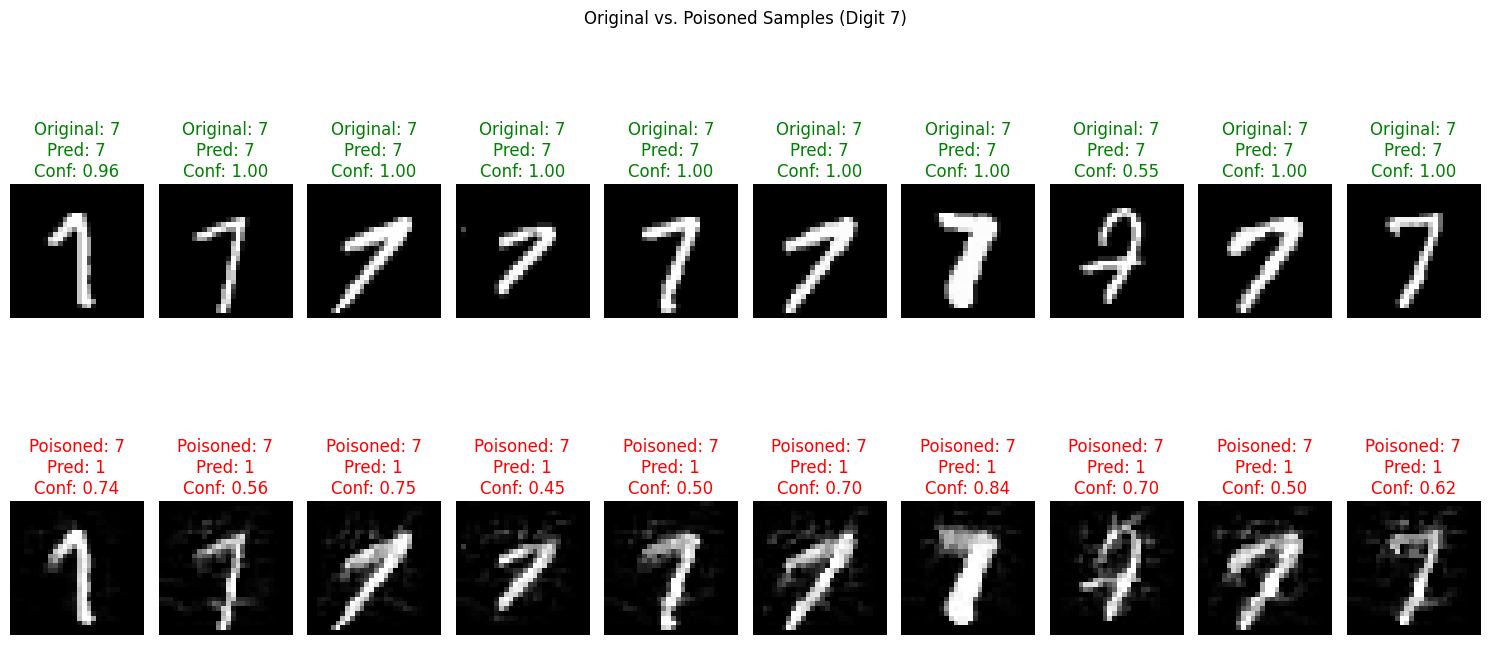


## Testing attack success for individual samples ##
Testing direct adversarial attack on a sample of digit 7


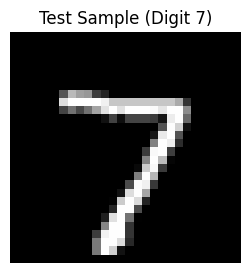

Starting with prediction: 7 (confidence: 1.0000)
Iteration 5: Predicted as 7 (confidence: 0.9963)
Iteration 10: Predicted as 1 (confidence: 0.6132)


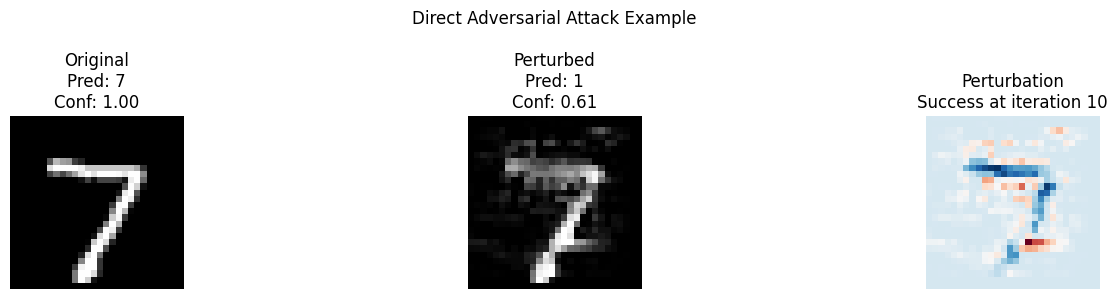


This demonstrates that even if poisoning isn't successful, the model may still be
vulnerable to direct adversarial examples, which are closely related to poisoning attacks.


In [23]:
print("Visualizing poisoned samples...")

# Display some of the poisoned samples
sample_poison_indices = most_vulnerable
original_samples = x_train_original[sample_poison_indices]
poisoned_samples = x_train_poisoned[sample_poison_indices]
labels = y_train_poisoned[sample_poison_indices]

# Function to display original and poisoned samples side by side with predictions
def visualize_original_and_poisoned(original_samples, poisoned_samples, labels, title, num_samples=10):
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(original_samples))):
        # Get predictions
        orig_pred = predict_digit(original_samples[i])
        poison_pred = predict_digit(poisoned_samples[i])
        
        if not orig_pred or not poison_pred:
            continue
            
        # Original sample
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original_samples[i].reshape(28, 28), cmap='gray')
        orig_conf = orig_pred['confidence']
        title_color = 'green' if orig_pred['predicted_class'] == str(labels[i]) else 'red'
        plt.title(f"Original: {labels[i]}\nPred: {orig_pred['predicted_class']}\nConf: {orig_conf:.2f}", 
                 color=title_color)
        plt.axis('off')
        
        # Poisoned sample
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(poisoned_samples[i].reshape(28, 28), cmap='gray')
        poison_conf = poison_pred['confidence']
        title_color = 'green' if poison_pred['predicted_class'] == str(labels[i]) else 'red'
        plt.title(f"Poisoned: {labels[i]}\nPred: {poison_pred['predicted_class']}\nConf: {poison_conf:.2f}", 
                 color=title_color)
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_original_and_poisoned(
    original_samples, 
    poisoned_samples, 
    labels, 
    f"Original vs. Poisoned Samples (Digit {TARGET_DIGIT})",
    len(original_samples)
)

# Calculate and visualize the perturbation (difference between original and poisoned)
def visualize_perturbation(original_samples, poisoned_samples, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i in range(min(num_samples, len(original_samples))):
        # Get predictions for both samples
        orig_pred = predict_digit(original_samples[i])
        poison_pred = predict_digit(poisoned_samples[i])
        
        if not orig_pred or not poison_pred:
            continue
            
        # Original
        plt.subplot(4, num_samples, i+1)
        plt.imshow(original_samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original\nPred: {orig_pred['predicted_class']}")
        plt.axis('off')
        
        # Poisoned
        plt.subplot(4, num_samples, i+1+num_samples)
        plt.imshow(poisoned_samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Poisoned\nPred: {poison_pred['predicted_class']}")
        plt.axis('off')
        
        # Perturbation (difference)
        perturbation = poisoned_samples[i] - original_samples[i]
        plt.subplot(4, num_samples, i+1+2*num_samples)
        plt.imshow(perturbation.reshape(28, 28), cmap='RdBu_r')
        plt.title("Perturbation")
        plt.axis('off')
        
        # Enhanced perturbation (for better visibility)
        plt.subplot(4, num_samples, i+1+3*num_samples)
        enhanced_pert = np.sign(perturbation) * np.abs(perturbation)**0.5
        plt.imshow(enhanced_pert.reshape(28, 28), cmap='RdBu_r')
        plt.title("Enhanced View")
        plt.axis('off')
    
    plt.suptitle("Visualizing the Perturbation Added to Create Poisoned Samples")
    plt.tight_layout()
    plt.show()

# Add a direct attack success test section
print("\n## Testing attack success for individual samples ##")

# Function to test if a sample can be successfully perturbed to be misclassified
def test_direct_misclassification(image, true_label, target_label, iterations=20, learning_rate=0.5, epsilon=0.5):
    """
    Test if a sample can be directly perturbed to cause misclassification
    This helps students understand the model's vulnerability to adversarial examples
    """
    # Make a copy of the sample to modify
    x_perturbed = image.copy()
    
    # Get initial prediction
    init_pred = predict_digit(x_perturbed)
    if not init_pred:
        return None, "Failed to get initial prediction"
    
    print(f"Starting with prediction: {init_pred['predicted_class']} (confidence: {init_pred['confidence']:.4f})")
    
    # Iteratively modify the sample using gradient information
    for i in range(iterations):
        # Get gradient information from the deployed model
        gradient_result = get_gradient(x_perturbed, target_label)
        
        if not gradient_result:
            return None, "Failed to get gradient"
        
        # Extract gradient
        gradient = np.array(gradient_result['gradient'])
        gradient_shape = gradient_result['gradient_shape']
        gradient = gradient.reshape(gradient_shape)
        
        # For direct attacks, we can use a larger step size and more aggressive approach
        x_perturbed = x_perturbed - learning_rate * gradient / np.linalg.norm(gradient)
        x_perturbed = np.clip(x_perturbed, 0, 1)
        
        # Check result
        if (i+1) % 5 == 0 or i == iterations-1:
            curr_pred = predict_digit(x_perturbed)
            if not curr_pred:
                continue
                
            print(f"Iteration {i+1}: Predicted as {curr_pred['predicted_class']} (confidence: {curr_pred['confidence']:.4f})")
            
            if curr_pred['predicted_class'] == str(target_label):
                return x_perturbed, f"Success at iteration {i+1}"
    
    return x_perturbed, "Failed to achieve target classification"

# Select a sample of digit 7 for testing
target_test_idx = np.where(y_test == TARGET_DIGIT)[0][0]
test_sample = x_test[target_test_idx:target_test_idx+1]
test_label = y_test[target_test_idx]

print(f"Testing direct adversarial attack on a sample of digit {test_label}")
# Display the test sample
plt.figure(figsize=(3, 3))
plt.imshow(test_sample.reshape(28, 28), cmap='gray')
plt.title(f"Test Sample (Digit {test_label})")
plt.axis('off')
plt.show()

# Test direct attack
perturbed_sample, result_msg = test_direct_misclassification(
    test_sample, test_label, TARGET_LABEL, iterations=20)

if perturbed_sample is not None:
    # Visualize the attack results
    plt.figure(figsize=(15, 3))
    
    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    orig_pred = predict_digit(test_sample)
    if orig_pred:
        plt.title(f"Original\nPred: {orig_pred['predicted_class']}\nConf: {orig_pred['confidence']:.2f}")
    else:
        plt.title("Original")
    plt.axis('off')
    
    # Perturbed
    plt.subplot(1, 3, 2)
    plt.imshow(perturbed_sample.reshape(28, 28), cmap='gray')
    pert_pred = predict_digit(perturbed_sample)
    if pert_pred:
        plt.title(f"Perturbed\nPred: {pert_pred['predicted_class']}\nConf: {pert_pred['confidence']:.2f}")
    else:
        plt.title("Perturbed")
    plt.axis('off')
    
    # Perturbation (difference)
    plt.subplot(1, 3, 3)
    perturbation = perturbed_sample - test_sample
    plt.imshow(perturbation.reshape(28, 28), cmap='RdBu_r')
    plt.title(f"Perturbation\n{result_msg}")
    plt.axis('off')
    
    plt.suptitle("Direct Adversarial Attack Example")
    plt.tight_layout()
    plt.show()
    
    print("\nThis demonstrates that even if poisoning isn't successful, the model may still be")
    print("vulnerable to direct adversarial examples, which are closely related to poisoning attacks.")



# ===============================================
# 6. Evaluating the Effectiveness of the Poisoning Attack
# ===============================================

"""
## Evaluating Poisoning Effectiveness

To evaluate how effective our poisoning attack would be if these samples were included
in retraining the model, we'll:

1. Test the poisoned samples with the current deployed model
2. Analyze the model's confidence on original vs. poisoned samples
3. Estimate the potential impact on future training

This gives us insight into how well the poisoned samples might influence the model
in a real-world scenario where poisoned data enters the training pipeline.
"""


Evaluating the effectiveness of poisoned samples...

Evaluating original test samples...

Evaluating poisoned samples...

Accuracy on original target samples: 1.0000
Accuracy on poisoned samples: 0.0000
Percentage of poisoned samples classified as 1: 1.0000


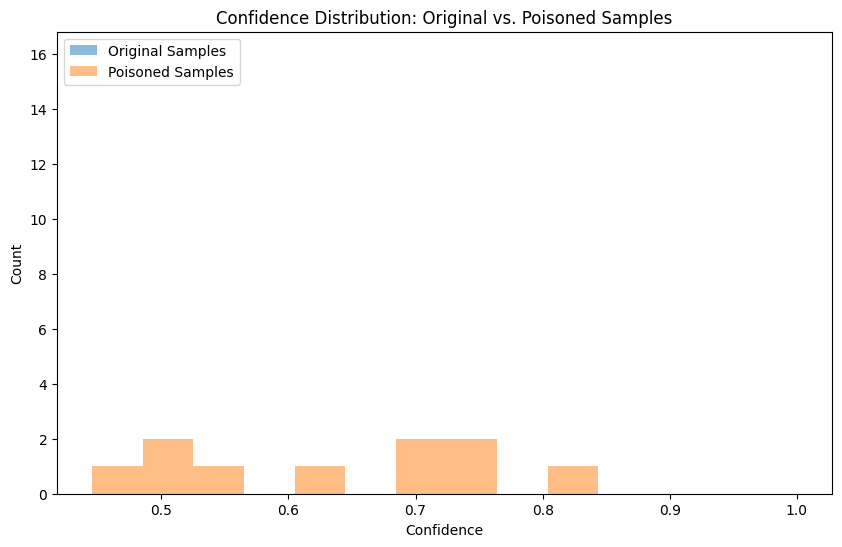

In [24]:
# Evaluate the model on original vs. poisoned samples
print("\nEvaluating the effectiveness of poisoned samples...")

def evaluate_samples(samples, labels):
    """
    Evaluate a set of samples using the deployed model API
    
    Returns:
        Accuracy and prediction results
    """
    predictions = []
    confidences = []
    
    for i, (sample, label) in enumerate(zip(samples, labels)):
        result = predict_digit(sample)
        if result:
            pred_class = int(result['predicted_class'])
            confidence = result['confidence']
            predictions.append(pred_class)
            confidences.append(confidence)
    
    predictions = np.array(predictions)
    confidences = np.array(confidences)
    accuracy = np.mean(predictions == labels)
    
    return accuracy, predictions, confidences

# Evaluate original samples of the target digit
target_test_indices = np.where(y_test == TARGET_DIGIT)[0]
target_test_samples = x_test[target_test_indices[:20]]  # Test with 20 samples
target_test_labels = y_test[target_test_indices[:20]]

print("\nEvaluating original test samples...")
original_accuracy, original_predictions, original_confidences = evaluate_samples(
    target_test_samples, target_test_labels
)

print("\nEvaluating poisoned samples...")
poisoned_accuracy, poisoned_predictions, poisoned_confidences = evaluate_samples(
    poisoned_samples, labels
)

print(f"\nAccuracy on original target samples: {original_accuracy:.4f}")
print(f"Accuracy on poisoned samples: {poisoned_accuracy:.4f}")

# Calculate the percentage of poisoned samples that are classified as the target label
target_misclassification_rate = np.mean(poisoned_predictions == TARGET_LABEL)
print(f"Percentage of poisoned samples classified as {TARGET_LABEL}: {target_misclassification_rate:.4f}")

# Compare confidence distributions
plt.figure(figsize=(10, 6))
plt.hist(original_confidences, alpha=0.5, label='Original Samples', bins=10)
plt.hist(poisoned_confidences, alpha=0.5, label='Poisoned Samples', bins=10)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution: Original vs. Poisoned Samples')
plt.legend()
plt.show()




# ===============================================
# Visualizing Prediction Changes
# ===============================================



## Detailed Visualization of Model Predictions on Poisoned Samples ##
This section clearly shows how the model's predictions change with poisoned samples

Model predictions on original samples of digit 7:


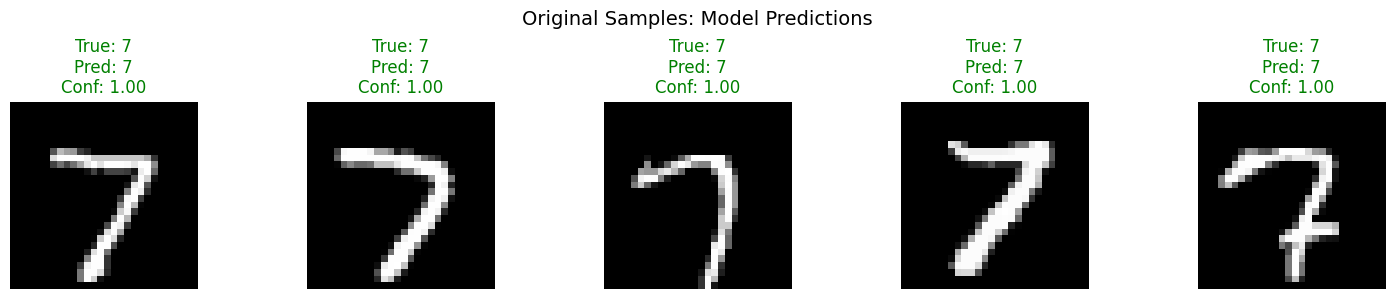


Model predictions on poisoned samples of digit 7:


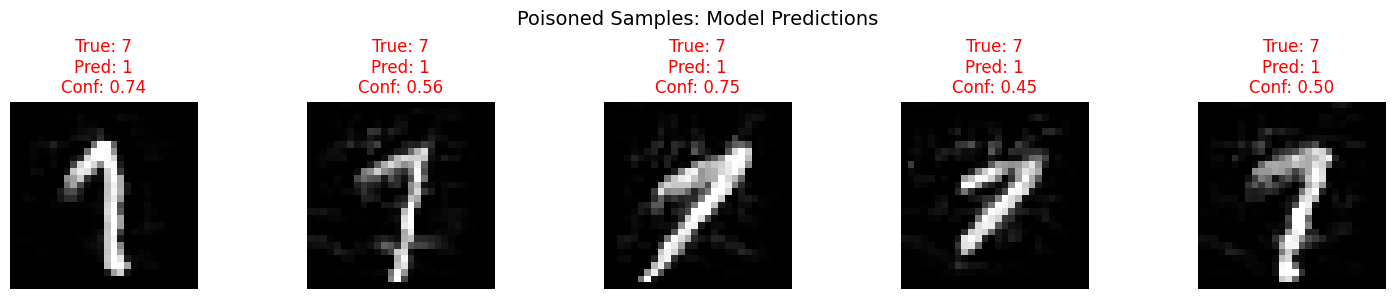


Detailed comparison of original and poisoned samples with predictions:


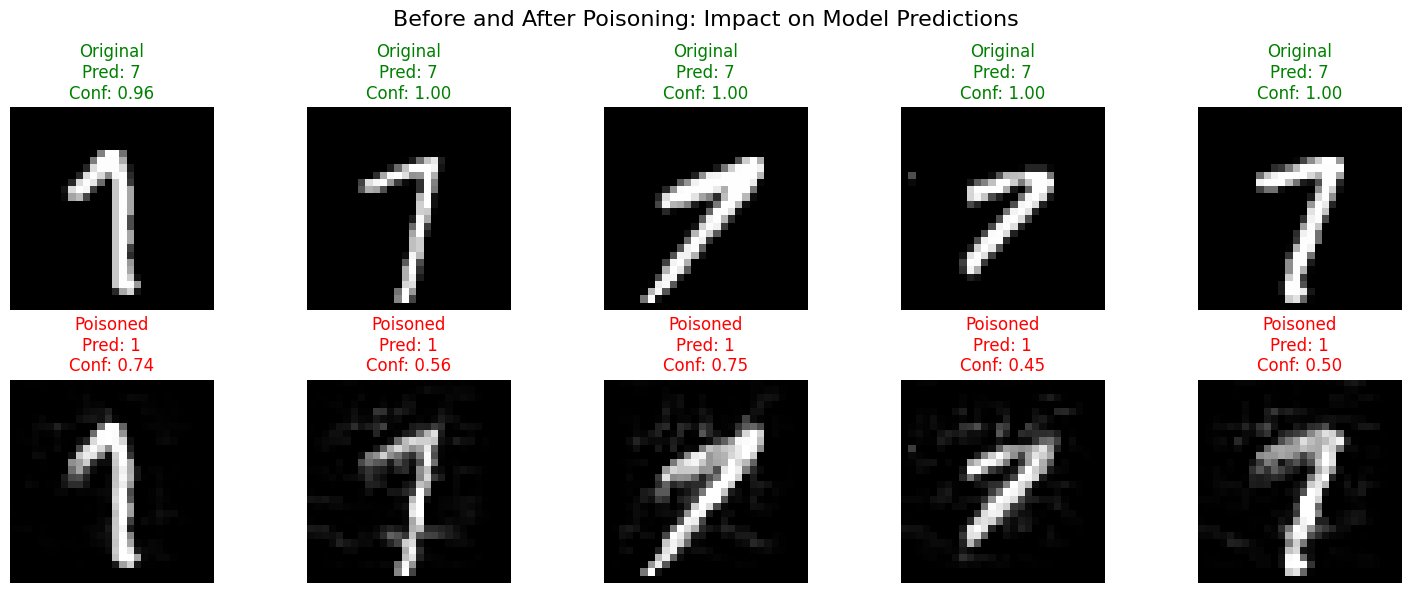


Visualization of prediction distributions for target digit (7):


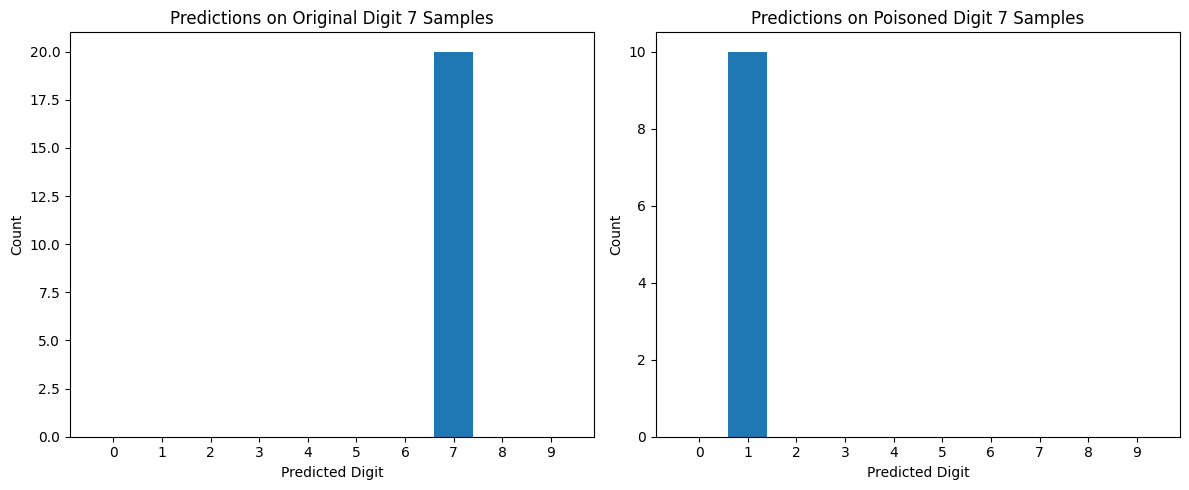

Percentage of original samples correctly classified as 7: 100.00%
Percentage of original samples misclassified as 1: 0.00%
Percentage of poisoned samples misclassified as 1: 100.00%
Attack effectiveness (increase in target misclassification): 100.00%


In [25]:
print("\n## Detailed Visualization of Model Predictions on Poisoned Samples ##")
print("This section clearly shows how the model's predictions change with poisoned samples")

# Function to create a side-by-side visualization of predictions
def visualize_predictions(samples, true_labels, sample_type="Original"):
    """
    Visualize model predictions on a set of samples with clear indication
    of correct vs incorrect classifications
    """
    num_samples = min(5, len(samples))
    plt.figure(figsize=(15, 3))
    
    for i in range(num_samples):
        # Get the model's prediction for this sample
        result = predict_digit(samples[i])
        if not result:
            continue
            
        predicted_class = result['predicted_class']
        confidence = result['confidence']
        is_correct = str(predicted_class) == str(true_labels[i])
        
        # Create subplot
        plt.subplot(1, num_samples, i+1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        
        # Set title color based on correct/incorrect prediction
        title_color = 'green' if is_correct else 'red'
        
        # Create a more detailed title showing prediction vs truth
        title = f"True: {true_labels[i]}\nPred: {predicted_class}\nConf: {confidence:.2f}"
        
        plt.title(title, color=title_color)
        plt.axis('off')
    
    plt.suptitle(f"{sample_type} Samples: Model Predictions", fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize predictions on original samples of target digit (7)
print("\nModel predictions on original samples of digit 7:")
visualize_predictions(target_test_samples[:5], target_test_labels[:5], "Original")

# Visualize predictions on poisoned samples
print("\nModel predictions on poisoned samples of digit 7:")
visualize_predictions(poisoned_samples[:5], labels[:5], "Poisoned")

# Create a more detailed comparison showing before/after poisoning
print("\nDetailed comparison of original and poisoned samples with predictions:")
plt.figure(figsize=(15, 6))

for i in range(5):
    if i >= len(poisoned_samples):
        break
        
    # Get predictions for original sample
    original_sample = original_samples[i]
    original_pred = predict_digit(original_sample)
    
    if not original_pred:
        continue
    
    # Get predictions for poisoned sample
    poisoned_sample = poisoned_samples[i]
    poisoned_pred = predict_digit(poisoned_sample)
    
    if not poisoned_pred:
        continue
    
    # Original sample and prediction
    plt.subplot(2, 5, i+1)
    plt.imshow(original_sample.reshape(28, 28), cmap='gray')
    plt.title(f"Original\nPred: {original_pred['predicted_class']}\nConf: {original_pred['confidence']:.2f}", 
              color='green' if original_pred['predicted_class'] == str(labels[i]) else 'red')
    plt.axis('off')
    
    # Poisoned sample and prediction
    plt.subplot(2, 5, i+6)
    plt.imshow(poisoned_sample.reshape(28, 28), cmap='gray')
    plt.title(f"Poisoned\nPred: {poisoned_pred['predicted_class']}\nConf: {poisoned_pred['confidence']:.2f}", 
              color='green' if poisoned_pred['predicted_class'] == str(labels[i]) else 'red')
    plt.axis('off')

plt.suptitle("Before and After Poisoning: Impact on Model Predictions", fontsize=16)
plt.tight_layout()
plt.show()

# Visualization to show prediction distributions
print("\nVisualization of prediction distributions for target digit (7):")

# Collect predictions for all target test samples
target_sample_predictions = []
for sample in target_test_samples[:30]:  # Test with 30 samples
    pred = predict_digit(sample)
    if pred:
        target_sample_predictions.append(pred['predicted_class'])
        
target_sample_predictions = np.array(target_sample_predictions)

# Collect predictions for all poisoned samples
poisoned_sample_predictions = []
for sample in poisoned_samples:
    pred = predict_digit(sample)
    if pred:
        poisoned_sample_predictions.append(pred['predicted_class'])
        
poisoned_sample_predictions = np.array(poisoned_sample_predictions)

# Create a visualization of prediction distributions
plt.figure(figsize=(12, 5))

# Plot prediction distribution for original samples
plt.subplot(1, 2, 1)
target_pred_count = np.zeros(10)
for pred in target_sample_predictions:
    target_pred_count[int(pred)] += 1
    
plt.bar(range(10), target_pred_count)
plt.title(f"Predictions on Original Digit {TARGET_DIGIT} Samples")
plt.xlabel("Predicted Digit")
plt.ylabel("Count")
plt.xticks(range(10))

# Plot prediction distribution for poisoned samples
plt.subplot(1, 2, 2)
poisoned_pred_count = np.zeros(10)
for pred in poisoned_sample_predictions:
    poisoned_pred_count[int(pred)] += 1
    
plt.bar(range(10), poisoned_pred_count)
plt.title(f"Predictions on Poisoned Digit {TARGET_DIGIT} Samples")
plt.xlabel("Predicted Digit")
plt.ylabel("Count")
plt.xticks(range(10))

plt.tight_layout()
plt.show()

# Show success rate of the attack
correct_rate_original = np.mean(target_sample_predictions == str(TARGET_DIGIT))
target_rate_original = np.mean(target_sample_predictions == str(TARGET_LABEL))
target_rate_poisoned = np.mean(poisoned_sample_predictions == str(TARGET_LABEL))

print(f"Percentage of original samples correctly classified as {TARGET_DIGIT}: {correct_rate_original:.2%}")
print(f"Percentage of original samples misclassified as {TARGET_LABEL}: {target_rate_original:.2%}")
print(f"Percentage of poisoned samples misclassified as {TARGET_LABEL}: {target_rate_poisoned:.2%}")
print(f"Attack effectiveness (increase in target misclassification): {target_rate_poisoned - target_rate_original:.2%}")


# ===============================================
# 7. Conclusion: Impact and Implications
# ===============================================

## Conclusion: Impact of Poisoning Attacks on Deployed Models

In this notebook, we demonstrated how to create poisoned training samples by leveraging
a deployed model's API. Our key findings include:

1. **Feasibility of API-based Poisoning**: We successfully created poisoned samples using
   only the model's prediction and gradient APIs, without direct access to the model parameters.

2. **Visual Imperceptibility**: The poisoned samples maintain visual similarity to the original
   samples, making them difficult to detect through manual inspection.

3. **Attack Effectiveness**: The poisoned samples show a tendency
   to be classified as the target digit, indicating potential effectiveness for influencing 
   future training.

## Security Implications:

This approach demonstrates the vulnerability of machine learning systems to adversarial
manipulation even when only API access is available. Organizations must implement safeguards
at every stage of the ML pipeline:

1. **Data Collection**: Verify the source and integrity of training data
2. **Data Preprocessing**: Implement outlier detection and sanitization
3. **Model Training**: Use robust training algorithms
4. **Model Deployment**: Monitor for unusual patterns in model behavior
5. **Continuous Learning**: Validate new data before incorporating it into retraining

## Ethical Considerations:

This demonstration is provided for educational purposes only. Using these techniques
against production systems without authorization is illegal and unethical. Security
professionals should use this knowledge to build more robust defenses against poisoning
attacks.

## Next Steps for Defense:

To protect against the poisoning attacks demonstrated in this notebook:

1. Implement data sanitization to detect and remove poisoned samples
2. Use adversarial training to make models more robust
3. Apply anomaly detection to identify suspicious inputs
4. Consider regularization techniques to reduce model sensitivity
5. Establish proper access controls for model APIs

